PyTorch version: 2.1.2
CUDA version: 12.1



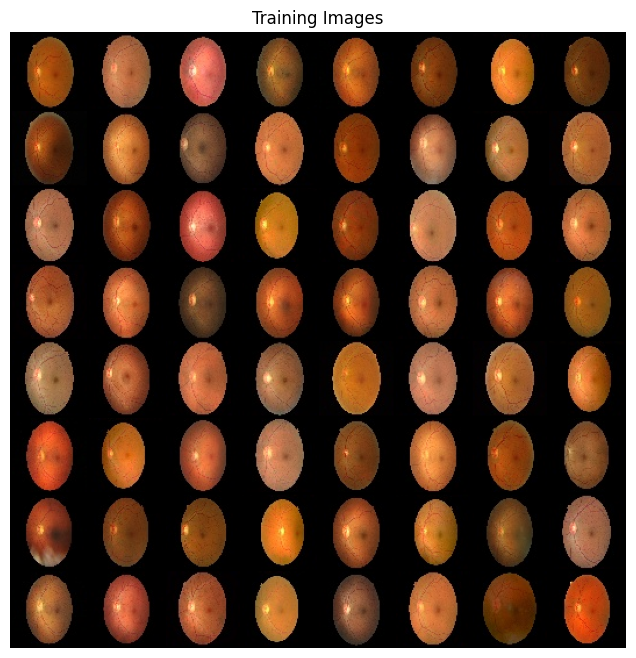

In [36]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.autograd import Variable

DATA_PATH = '/kaggle/input/gan-test-data/Image_DATA/Test'
BATCH_SIZE = 128
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 2000
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 0.001
seed = 1

CUDA = torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
if CUDA:
    print(f"CUDA version: {torch.version.cuda}\n")

torch.cuda.manual_seed(seed)

device = torch.device("cuda" if CUDA else "cpu")
cudnn.benchmark = True

# Data preprocessing
dataset = dset.ImageFolder(root=DATA_PATH,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [37]:
# create Generator and Discriminator
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


class generator(nn.Module):
    # initializers
    def __init__(self, d=G_HIDDEN):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(Z_DIM, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=D_HIDDEN):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        #self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

generator(
  (deconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
 

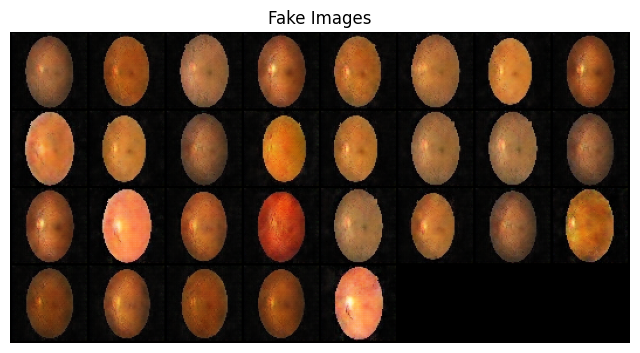

[51/2000][0/9]	Loss_D: 0.6547	Loss_G: 14.8497	D(x): 1.0000	D(G(z)): 0.2914 / 0.0004
[52/2000][0/9]	Loss_D: 0.0072	Loss_G: 7.4623	D(x): 0.9985	D(G(z)): 0.0056 / 0.0034
[53/2000][0/9]	Loss_D: 0.0183	Loss_G: 6.3271	D(x): 0.9990	D(G(z)): 0.0169 / 0.0035
[54/2000][0/9]	Loss_D: 0.0219	Loss_G: 6.2751	D(x): 0.9990	D(G(z)): 0.0204 / 0.0040
[55/2000][0/9]	Loss_D: 0.0282	Loss_G: 6.1718	D(x): 0.9997	D(G(z)): 0.0268 / 0.0039
[56/2000][0/9]	Loss_D: 0.0073	Loss_G: 6.9488	D(x): 0.9955	D(G(z)): 0.0027 / 0.0019
[57/2000][0/9]	Loss_D: 0.0425	Loss_G: 6.7649	D(x): 0.9996	D(G(z)): 0.0406 / 0.0025
[58/2000][0/9]	Loss_D: 0.1152	Loss_G: 9.2689	D(x): 0.9995	D(G(z)): 0.0989 / 0.0003
[59/2000][0/9]	Loss_D: 0.0058	Loss_G: 8.3425	D(x): 0.9949	D(G(z)): 0.0006 / 0.0007
[60/2000][0/9]	Loss_D: 0.0367	Loss_G: 7.5341	D(x): 0.9987	D(G(z)): 0.0337 / 0.0051
[61/2000][0/9]	Loss_D: 0.6457	Loss_G: 19.6185	D(x): 0.9999	D(G(z)): 0.2920 / 0.0000
[62/2000][0/9]	Loss_D: 0.3455	Loss_G: 13.5754	D(x): 0.9999	D(G(z)): 0.1577 / 0.0001
[

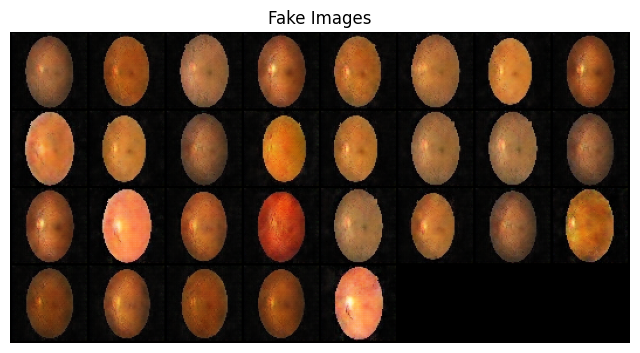

[101/2000][0/9]	Loss_D: 0.1385	Loss_G: 5.2962	D(x): 0.9258	D(G(z)): 0.0014 / 0.0296
[102/2000][0/9]	Loss_D: 0.0031	Loss_G: 7.9991	D(x): 0.9995	D(G(z)): 0.0025 / 0.0031
[103/2000][0/9]	Loss_D: 0.0198	Loss_G: 6.5572	D(x): 0.9996	D(G(z)): 0.0189 / 0.0032
[104/2000][0/9]	Loss_D: 0.1501	Loss_G: 11.3798	D(x): 0.9969	D(G(z)): 0.1187 / 0.0001
[105/2000][0/9]	Loss_D: 0.0372	Loss_G: 11.9409	D(x): 0.9988	D(G(z)): 0.0296 / 0.0015
[106/2000][0/9]	Loss_D: 0.0027	Loss_G: 10.3750	D(x): 0.9981	D(G(z)): 0.0008 / 0.0007
[107/2000][0/9]	Loss_D: 0.0197	Loss_G: 7.1819	D(x): 0.9975	D(G(z)): 0.0169 / 0.0055
[108/2000][0/9]	Loss_D: 2.2582	Loss_G: 35.2456	D(x): 0.9999	D(G(z)): 0.7019 / 0.0000
[109/2000][0/9]	Loss_D: 0.0555	Loss_G: 9.1832	D(x): 0.9996	D(G(z)): 0.0464 / 0.0028
[110/2000][0/9]	Loss_D: 0.1674	Loss_G: 5.7034	D(x): 0.8983	D(G(z)): 0.0043 / 0.0096
[111/2000][0/9]	Loss_D: 0.1110	Loss_G: 6.6863	D(x): 0.9987	D(G(z)): 0.0956 / 0.0030
[112/2000][0/9]	Loss_D: 0.1264	Loss_G: 7.0361	D(x): 0.9990	D(G(z)): 0.10

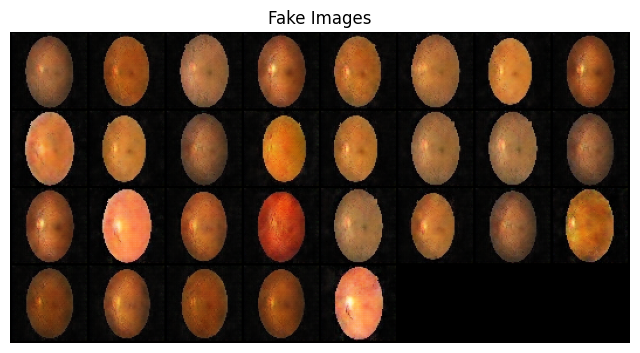

[151/2000][0/9]	Loss_D: 0.0172	Loss_G: 5.8715	D(x): 0.9899	D(G(z)): 0.0065 / 0.0053
[152/2000][0/9]	Loss_D: 0.0167	Loss_G: 5.5381	D(x): 0.9935	D(G(z)): 0.0099 / 0.0069
[153/2000][0/9]	Loss_D: 0.0171	Loss_G: 6.2826	D(x): 0.9976	D(G(z)): 0.0144 / 0.0039
[154/2000][0/9]	Loss_D: 0.0288	Loss_G: 5.8780	D(x): 0.9961	D(G(z)): 0.0244 / 0.0045
[155/2000][0/9]	Loss_D: 0.0052	Loss_G: 6.1728	D(x): 0.9990	D(G(z)): 0.0042 / 0.0058
[156/2000][0/9]	Loss_D: 1.1241	Loss_G: 22.5638	D(x): 0.9998	D(G(z)): 0.4921 / 0.0000
[157/2000][0/9]	Loss_D: 0.0802	Loss_G: 11.7511	D(x): 0.9919	D(G(z)): 0.0566 / 0.0019
[158/2000][0/9]	Loss_D: 0.0805	Loss_G: 5.3992	D(x): 0.9729	D(G(z)): 0.0345 / 0.0095
[159/2000][0/9]	Loss_D: 1.4379	Loss_G: 19.1773	D(x): 0.9996	D(G(z)): 0.5716 / 0.0000
[160/2000][0/9]	Loss_D: 0.0171	Loss_G: 7.0639	D(x): 0.9996	D(G(z)): 0.0161 / 0.0041
[161/2000][0/9]	Loss_D: 0.0247	Loss_G: 5.5233	D(x): 0.9965	D(G(z)): 0.0204 / 0.0062
[162/2000][0/9]	Loss_D: 0.1056	Loss_G: 6.7294	D(x): 0.9990	D(G(z)): 0.088

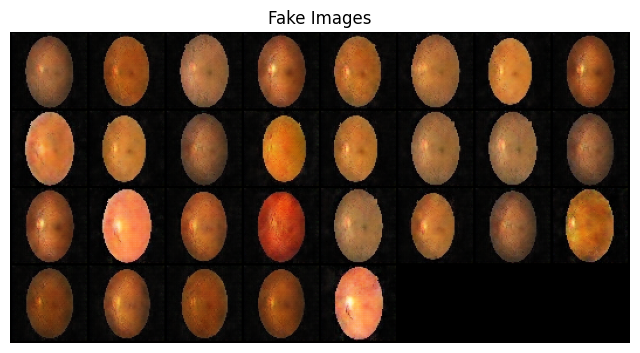

[201/2000][0/9]	Loss_D: 0.0070	Loss_G: 6.3297	D(x): 0.9973	D(G(z)): 0.0043 / 0.0059
[202/2000][0/9]	Loss_D: 0.0043	Loss_G: 7.2850	D(x): 0.9984	D(G(z)): 0.0027 / 0.0022
[203/2000][0/9]	Loss_D: 0.0051	Loss_G: 6.7364	D(x): 0.9987	D(G(z)): 0.0038 / 0.0033
[204/2000][0/9]	Loss_D: 0.0125	Loss_G: 6.3006	D(x): 0.9996	D(G(z)): 0.0118 / 0.0035
[205/2000][0/9]	Loss_D: 0.0086	Loss_G: 5.1079	D(x): 0.9981	D(G(z)): 0.0066 / 0.0103
[206/2000][0/9]	Loss_D: 0.0186	Loss_G: 5.6457	D(x): 0.9892	D(G(z)): 0.0075 / 0.0059
[207/2000][0/9]	Loss_D: 0.0451	Loss_G: 6.9793	D(x): 0.9991	D(G(z)): 0.0424 / 0.0016
[208/2000][0/9]	Loss_D: 0.0032	Loss_G: 7.7735	D(x): 0.9978	D(G(z)): 0.0010 / 0.0008
[209/2000][0/9]	Loss_D: 0.0253	Loss_G: 5.1883	D(x): 0.9806	D(G(z)): 0.0046 / 0.0103
[210/2000][0/9]	Loss_D: 0.0092	Loss_G: 6.0570	D(x): 0.9995	D(G(z)): 0.0086 / 0.0041
[211/2000][0/9]	Loss_D: 2.8887	Loss_G: 36.6817	D(x): 0.9999	D(G(z)): 0.8590 / 0.0000
[212/2000][0/9]	Loss_D: 0.0166	Loss_G: 8.9235	D(x): 0.9918	D(G(z)): 0.0074 

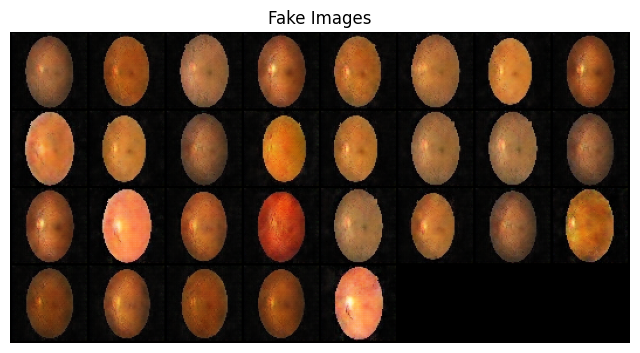

[251/2000][0/9]	Loss_D: 0.0042	Loss_G: 7.9552	D(x): 0.9980	D(G(z)): 0.0022 / 0.0015
[252/2000][0/9]	Loss_D: 0.0527	Loss_G: 6.1429	D(x): 0.9953	D(G(z)): 0.0293 / 0.0044
[253/2000][0/9]	Loss_D: 2.2851	Loss_G: 25.2828	D(x): 0.9999	D(G(z)): 0.7493 / 0.0000
[254/2000][0/9]	Loss_D: 0.5478	Loss_G: 10.2983	D(x): 0.9997	D(G(z)): 0.2225 / 0.0004
[255/2000][0/9]	Loss_D: 0.0164	Loss_G: 6.7469	D(x): 0.9998	D(G(z)): 0.0158 / 0.0056
[256/2000][0/9]	Loss_D: 0.1026	Loss_G: 8.3097	D(x): 0.9997	D(G(z)): 0.0784 / 0.0029
[257/2000][0/9]	Loss_D: 0.0980	Loss_G: 7.0306	D(x): 0.9997	D(G(z)): 0.0814 / 0.0037
[258/2000][0/9]	Loss_D: 0.0162	Loss_G: 6.9294	D(x): 0.9946	D(G(z)): 0.0099 / 0.0032
[259/2000][0/9]	Loss_D: 0.0831	Loss_G: 8.3489	D(x): 0.9996	D(G(z)): 0.0581 / 0.0017
[260/2000][0/9]	Loss_D: 0.0181	Loss_G: 5.8317	D(x): 0.9947	D(G(z)): 0.0125 / 0.0072
[261/2000][0/9]	Loss_D: 0.0217	Loss_G: 5.9263	D(x): 0.9830	D(G(z)): 0.0036 / 0.0059
[262/2000][0/9]	Loss_D: 0.0459	Loss_G: 5.9554	D(x): 0.9734	D(G(z)): 0.0127

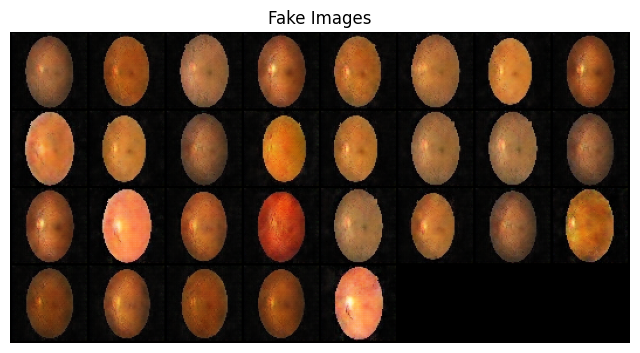

[301/2000][0/9]	Loss_D: 0.0094	Loss_G: 6.4397	D(x): 0.9970	D(G(z)): 0.0063 / 0.0042
[302/2000][0/9]	Loss_D: 0.0561	Loss_G: 6.3520	D(x): 0.9996	D(G(z)): 0.0514 / 0.0033
[303/2000][0/9]	Loss_D: 0.0090	Loss_G: 6.7143	D(x): 0.9962	D(G(z)): 0.0052 / 0.0028
[304/2000][0/9]	Loss_D: 0.0246	Loss_G: 5.9858	D(x): 0.9998	D(G(z)): 0.0233 / 0.0107
[305/2000][0/9]	Loss_D: 0.0009	Loss_G: 9.6749	D(x): 0.9992	D(G(z)): 0.0002 / 0.0002
[306/2000][0/9]	Loss_D: 0.0082	Loss_G: 6.2658	D(x): 0.9980	D(G(z)): 0.0061 / 0.0048
[307/2000][0/9]	Loss_D: 2.2016	Loss_G: 24.0675	D(x): 0.9999	D(G(z)): 0.6219 / 0.0000
[308/2000][0/9]	Loss_D: 0.0999	Loss_G: 5.5889	D(x): 0.9809	D(G(z)): 0.0491 / 0.0239
[309/2000][0/9]	Loss_D: 0.0498	Loss_G: 5.4821	D(x): 0.9849	D(G(z)): 0.0209 / 0.0082
[310/2000][0/9]	Loss_D: 1.1726	Loss_G: 22.8199	D(x): 0.9999	D(G(z)): 0.5376 / 0.0000
[311/2000][0/9]	Loss_D: 0.1353	Loss_G: 7.9450	D(x): 0.9706	D(G(z)): 0.0612 / 0.0037
[312/2000][0/9]	Loss_D: 1.8460	Loss_G: 22.9782	D(x): 1.0000	D(G(z)): 0.612

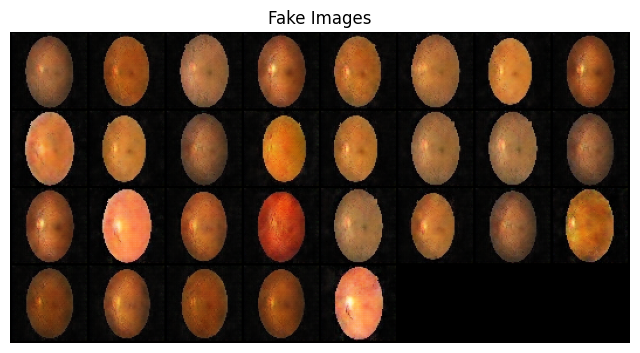

[351/2000][0/9]	Loss_D: 0.2689	Loss_G: 11.4626	D(x): 0.9974	D(G(z)): 0.2069 / 0.0006
[352/2000][0/9]	Loss_D: 0.1546	Loss_G: 14.4275	D(x): 0.9984	D(G(z)): 0.0965 / 0.0048
[353/2000][0/9]	Loss_D: 0.1446	Loss_G: 5.0419	D(x): 0.9198	D(G(z)): 0.0066 / 0.0160
[354/2000][0/9]	Loss_D: 0.0243	Loss_G: 5.4708	D(x): 0.9953	D(G(z)): 0.0192 / 0.0062
[355/2000][0/9]	Loss_D: 0.0682	Loss_G: 8.4211	D(x): 0.9996	D(G(z)): 0.0628 / 0.0005
[356/2000][0/9]	Loss_D: 0.0221	Loss_G: 5.7996	D(x): 0.9987	D(G(z)): 0.0189 / 0.0054
[357/2000][0/9]	Loss_D: 0.0187	Loss_G: 5.5011	D(x): 0.9893	D(G(z)): 0.0078 / 0.0081
[358/2000][0/9]	Loss_D: 0.1267	Loss_G: 6.4977	D(x): 0.9978	D(G(z)): 0.0734 / 0.0058
[359/2000][0/9]	Loss_D: 0.0178	Loss_G: 5.7355	D(x): 0.9935	D(G(z)): 0.0110 / 0.0066
[360/2000][0/9]	Loss_D: 0.1445	Loss_G: 7.5712	D(x): 0.9987	D(G(z)): 0.1170 / 0.0022
[361/2000][0/9]	Loss_D: 0.0432	Loss_G: 5.8883	D(x): 0.9968	D(G(z)): 0.0362 / 0.0055
[362/2000][0/9]	Loss_D: 0.0184	Loss_G: 6.5820	D(x): 0.9856	D(G(z)): 0.0036

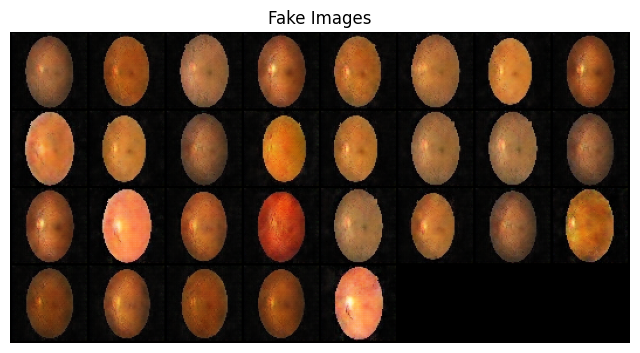

[401/2000][0/9]	Loss_D: 0.0209	Loss_G: 7.0693	D(x): 0.9878	D(G(z)): 0.0047 / 0.0024
[402/2000][0/9]	Loss_D: 0.0302	Loss_G: 5.8235	D(x): 0.9808	D(G(z)): 0.0098 / 0.0065
[403/2000][0/9]	Loss_D: 0.0225	Loss_G: 6.6231	D(x): 0.9824	D(G(z)): 0.0039 / 0.0034
[404/2000][0/9]	Loss_D: 5.4342	Loss_G: 31.0420	D(x): 1.0000	D(G(z)): 0.9176 / 0.0000
[405/2000][0/9]	Loss_D: 0.5596	Loss_G: 13.2809	D(x): 0.9957	D(G(z)): 0.2820 / 0.0003
[406/2000][0/9]	Loss_D: 0.0723	Loss_G: 6.3047	D(x): 0.9841	D(G(z)): 0.0505 / 0.0042
[407/2000][0/9]	Loss_D: 0.1718	Loss_G: 10.6876	D(x): 0.9981	D(G(z)): 0.1324 / 0.0001
[408/2000][0/9]	Loss_D: 0.0330	Loss_G: 5.7695	D(x): 0.9955	D(G(z)): 0.0272 / 0.0051
[409/2000][0/9]	Loss_D: 0.0141	Loss_G: 5.6309	D(x): 0.9970	D(G(z)): 0.0110 / 0.0066
[410/2000][0/9]	Loss_D: 4.7465	Loss_G: 34.1430	D(x): 1.0000	D(G(z)): 0.9662 / 0.0000
[411/2000][0/9]	Loss_D: 0.0836	Loss_G: 7.7758	D(x): 0.9957	D(G(z)): 0.0653 / 0.0033
[412/2000][0/9]	Loss_D: 0.6873	Loss_G: 16.1513	D(x): 0.9995	D(G(z)): 0.3

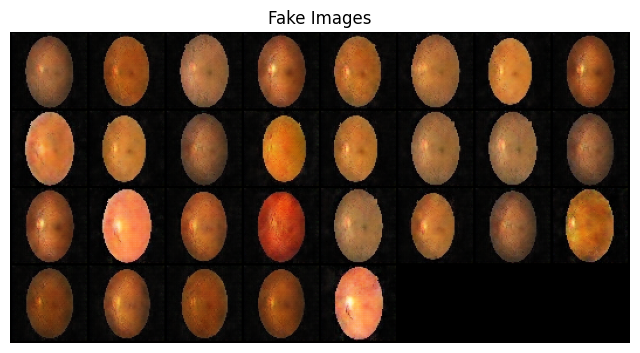

[451/2000][0/9]	Loss_D: 0.0149	Loss_G: 6.1279	D(x): 0.9906	D(G(z)): 0.0050 / 0.0046
[452/2000][0/9]	Loss_D: 0.0706	Loss_G: 9.0835	D(x): 0.9998	D(G(z)): 0.0570 / 0.0038
[453/2000][0/9]	Loss_D: 0.0133	Loss_G: 7.0560	D(x): 0.9995	D(G(z)): 0.0124 / 0.0031
[454/2000][0/9]	Loss_D: 0.0053	Loss_G: 6.2983	D(x): 0.9984	D(G(z)): 0.0037 / 0.0031
[455/2000][0/9]	Loss_D: 0.0063	Loss_G: 8.7590	D(x): 0.9942	D(G(z)): 0.0004 / 0.0005
[456/2000][0/9]	Loss_D: 0.0548	Loss_G: 7.0935	D(x): 0.9995	D(G(z)): 0.0504 / 0.0017
[457/2000][0/9]	Loss_D: 0.0199	Loss_G: 5.1863	D(x): 0.9998	D(G(z)): 0.0192 / 0.0104
[458/2000][0/9]	Loss_D: 6.3881	Loss_G: 31.5421	D(x): 1.0000	D(G(z)): 0.9735 / 0.0000
[459/2000][0/9]	Loss_D: 0.3514	Loss_G: 12.9396	D(x): 0.9957	D(G(z)): 0.1883 / 0.0011
[460/2000][0/9]	Loss_D: 0.1160	Loss_G: 7.0081	D(x): 0.9859	D(G(z)): 0.0885 / 0.0023
[461/2000][0/9]	Loss_D: 0.0300	Loss_G: 8.9713	D(x): 0.9915	D(G(z)): 0.0201 / 0.0093
[462/2000][0/9]	Loss_D: 0.1215	Loss_G: 7.3883	D(x): 0.9942	D(G(z)): 0.0925

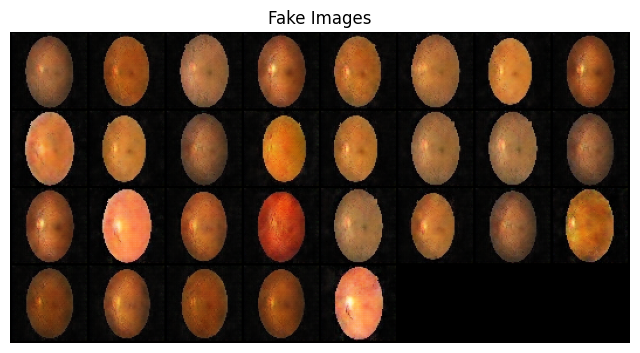

[501/2000][0/9]	Loss_D: 0.0647	Loss_G: 7.0243	D(x): 0.9984	D(G(z)): 0.0589 / 0.0018
[502/2000][0/9]	Loss_D: 0.0116	Loss_G: 5.4682	D(x): 0.9938	D(G(z)): 0.0052 / 0.0096
[503/2000][0/9]	Loss_D: 0.0165	Loss_G: 6.0111	D(x): 0.9995	D(G(z)): 0.0158 / 0.0044
[504/2000][0/9]	Loss_D: 0.0216	Loss_G: 6.2084	D(x): 0.9990	D(G(z)): 0.0198 / 0.0035
[505/2000][0/9]	Loss_D: 0.0056	Loss_G: 5.9816	D(x): 0.9988	D(G(z)): 0.0044 / 0.0063
[506/2000][0/9]	Loss_D: 0.0031	Loss_G: 9.7660	D(x): 0.9985	D(G(z)): 0.0016 / 0.0005
[507/2000][0/9]	Loss_D: 0.0297	Loss_G: 10.2141	D(x): 0.9753	D(G(z)): 0.0003 / 0.0003
[508/2000][0/9]	Loss_D: 0.0774	Loss_G: 6.8237	D(x): 0.9999	D(G(z)): 0.0696 / 0.0029
[509/2000][0/9]	Loss_D: 0.0108	Loss_G: 5.9922	D(x): 0.9999	D(G(z)): 0.0105 / 0.0052
[510/2000][0/9]	Loss_D: 0.0189	Loss_G: 6.5798	D(x): 0.9982	D(G(z)): 0.0167 / 0.0034
[511/2000][0/9]	Loss_D: 1.1216	Loss_G: 22.4096	D(x): 0.9999	D(G(z)): 0.4447 / 0.0000
[512/2000][0/9]	Loss_D: 0.5416	Loss_G: 10.6154	D(x): 0.9993	D(G(z)): 0.211

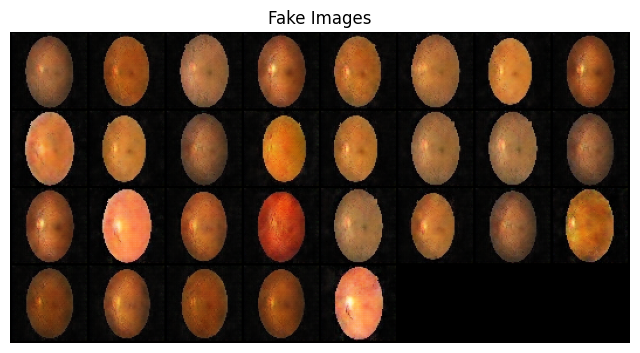

[551/2000][0/9]	Loss_D: 0.1215	Loss_G: 9.1437	D(x): 0.9848	D(G(z)): 0.0768 / 0.0014
[552/2000][0/9]	Loss_D: 0.0829	Loss_G: 6.7713	D(x): 0.9946	D(G(z)): 0.0640 / 0.0036
[553/2000][0/9]	Loss_D: 0.0239	Loss_G: 6.4130	D(x): 0.9960	D(G(z)): 0.0191 / 0.0031
[554/2000][0/9]	Loss_D: 0.6822	Loss_G: 14.1494	D(x): 0.9998	D(G(z)): 0.3372 / 0.0000
[555/2000][0/9]	Loss_D: 0.0074	Loss_G: 7.8805	D(x): 0.9985	D(G(z)): 0.0058 / 0.0031
[556/2000][0/9]	Loss_D: 0.0454	Loss_G: 6.8722	D(x): 0.9992	D(G(z)): 0.0419 / 0.0044
[557/2000][0/9]	Loss_D: 0.0215	Loss_G: 6.3418	D(x): 0.9948	D(G(z)): 0.0157 / 0.0039
[558/2000][0/9]	Loss_D: 0.0343	Loss_G: 5.5645	D(x): 0.9739	D(G(z)): 0.0059 / 0.0068
[559/2000][0/9]	Loss_D: 0.0664	Loss_G: 5.9445	D(x): 0.9820	D(G(z)): 0.0444 / 0.0059
[560/2000][0/9]	Loss_D: 0.0389	Loss_G: 4.9940	D(x): 0.9823	D(G(z)): 0.0198 / 0.0121
[561/2000][0/9]	Loss_D: 0.0093	Loss_G: 6.8701	D(x): 0.9938	D(G(z)): 0.0031 / 0.0022
[562/2000][0/9]	Loss_D: 6.1313	Loss_G: 30.4034	D(x): 1.0000	D(G(z)): 0.9406

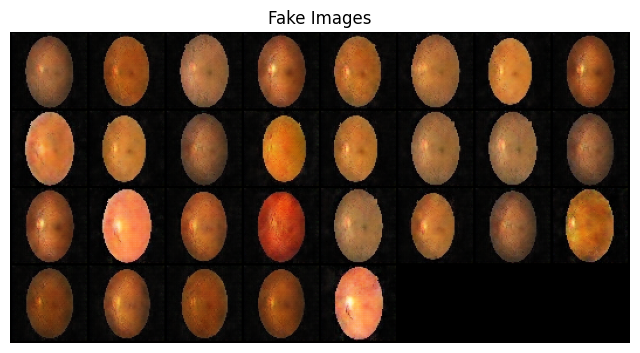

[601/2000][0/9]	Loss_D: 0.5536	Loss_G: 13.9472	D(x): 0.9996	D(G(z)): 0.2092 / 0.0027
[602/2000][0/9]	Loss_D: 0.0080	Loss_G: 7.2229	D(x): 0.9980	D(G(z)): 0.0058 / 0.0038
[603/2000][0/9]	Loss_D: 0.0301	Loss_G: 5.6727	D(x): 0.9888	D(G(z)): 0.0179 / 0.0077
[604/2000][0/9]	Loss_D: 1.2490	Loss_G: 27.1979	D(x): 0.9997	D(G(z)): 0.5820 / 0.0000
[605/2000][0/9]	Loss_D: 0.0446	Loss_G: 17.0825	D(x): 0.9833	D(G(z)): 0.0004 / 0.0000
[606/2000][0/9]	Loss_D: 0.2156	Loss_G: 6.4306	D(x): 0.9859	D(G(z)): 0.0488 / 0.0282
[607/2000][0/9]	Loss_D: 0.0280	Loss_G: 5.8422	D(x): 0.9853	D(G(z)): 0.0122 / 0.0066
[608/2000][0/9]	Loss_D: 0.0435	Loss_G: 5.9908	D(x): 0.9901	D(G(z)): 0.0321 / 0.0049
[609/2000][0/9]	Loss_D: 0.8160	Loss_G: 20.4033	D(x): 1.0000	D(G(z)): 0.4615 / 0.0000
[610/2000][0/9]	Loss_D: 0.0412	Loss_G: 7.8539	D(x): 0.9994	D(G(z)): 0.0381 / 0.0030
[611/2000][0/9]	Loss_D: 0.0257	Loss_G: 7.0875	D(x): 0.9882	D(G(z)): 0.0120 / 0.0027
[612/2000][0/9]	Loss_D: 0.0188	Loss_G: 6.1014	D(x): 0.9887	D(G(z)): 0.00

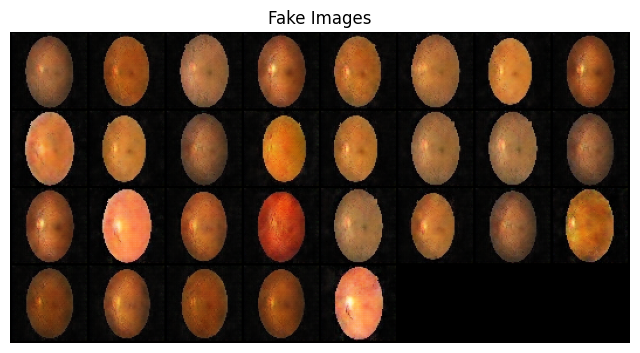

[651/2000][0/9]	Loss_D: 0.0049	Loss_G: 7.9472	D(x): 0.9998	D(G(z)): 0.0046 / 0.0027
[652/2000][0/9]	Loss_D: 0.0278	Loss_G: 6.2860	D(x): 0.9987	D(G(z)): 0.0254 / 0.0048
[653/2000][0/9]	Loss_D: 0.0290	Loss_G: 5.7527	D(x): 0.9752	D(G(z)): 0.0029 / 0.0076
[654/2000][0/9]	Loss_D: 0.0213	Loss_G: 6.1441	D(x): 0.9984	D(G(z)): 0.0185 / 0.0053
[655/2000][0/9]	Loss_D: 0.0280	Loss_G: 6.7831	D(x): 0.9822	D(G(z)): 0.0058 / 0.0030
[656/2000][0/9]	Loss_D: 0.0041	Loss_G: 6.6691	D(x): 0.9982	D(G(z)): 0.0023 / 0.0022
[657/2000][0/9]	Loss_D: 0.2817	Loss_G: 13.5555	D(x): 0.9994	D(G(z)): 0.2014 / 0.0005
[658/2000][0/9]	Loss_D: 0.0078	Loss_G: 6.8999	D(x): 0.9971	D(G(z)): 0.0048 / 0.0025
[659/2000][0/9]	Loss_D: 0.0149	Loss_G: 6.3893	D(x): 0.9955	D(G(z)): 0.0101 / 0.0035
[660/2000][0/9]	Loss_D: 0.0387	Loss_G: 6.2844	D(x): 0.9990	D(G(z)): 0.0339 / 0.0040
[661/2000][0/9]	Loss_D: 0.0290	Loss_G: 6.6174	D(x): 0.9994	D(G(z)): 0.0274 / 0.0026
[662/2000][0/9]	Loss_D: 0.0046	Loss_G: 8.0287	D(x): 0.9970	D(G(z)): 0.0016 

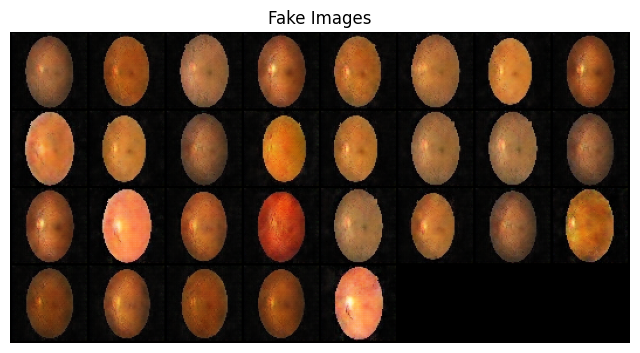

[701/2000][0/9]	Loss_D: 0.0100	Loss_G: 6.4702	D(x): 0.9945	D(G(z)): 0.0044 / 0.0040
[702/2000][0/9]	Loss_D: 0.0532	Loss_G: 6.7063	D(x): 0.9996	D(G(z)): 0.0497 / 0.0030
[703/2000][0/9]	Loss_D: 0.2750	Loss_G: 12.8665	D(x): 0.9997	D(G(z)): 0.1901 / 0.0002
[704/2000][0/9]	Loss_D: 0.0006	Loss_G: 9.9809	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003
[705/2000][0/9]	Loss_D: 0.1195	Loss_G: 9.7444	D(x): 0.9997	D(G(z)): 0.0834 / 0.0005
[706/2000][0/9]	Loss_D: 1.5197	Loss_G: 20.2793	D(x): 1.0000	D(G(z)): 0.3242 / 0.0000
[707/2000][0/9]	Loss_D: 0.0684	Loss_G: 8.3014	D(x): 0.9989	D(G(z)): 0.0440 / 0.0015
[708/2000][0/9]	Loss_D: 0.0526	Loss_G: 6.6217	D(x): 0.9986	D(G(z)): 0.0480 / 0.0072
[709/2000][0/9]	Loss_D: 0.0123	Loss_G: 6.1528	D(x): 0.9987	D(G(z)): 0.0108 / 0.0040
[710/2000][0/9]	Loss_D: 0.0479	Loss_G: 7.1948	D(x): 0.9982	D(G(z)): 0.0439 / 0.0023
[711/2000][0/9]	Loss_D: 0.0135	Loss_G: 6.4845	D(x): 0.9921	D(G(z)): 0.0051 / 0.0027
[712/2000][0/9]	Loss_D: 5.1132	Loss_G: 23.3659	D(x): 1.0000	D(G(z)): 0.519

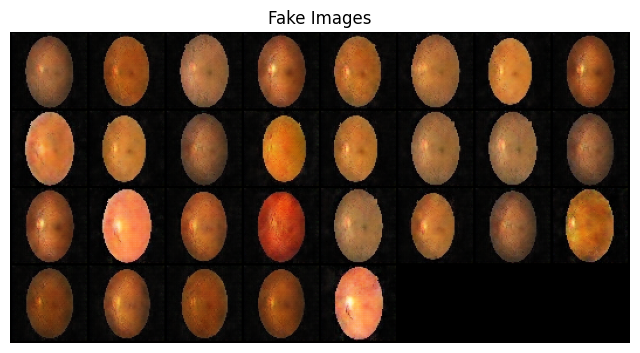

[751/2000][0/9]	Loss_D: 5.2066	Loss_G: 24.0642	D(x): 1.0000	D(G(z)): 0.6135 / 0.0235
[752/2000][0/9]	Loss_D: 0.5159	Loss_G: 11.6546	D(x): 0.9998	D(G(z)): 0.1766 / 0.0010
[753/2000][0/9]	Loss_D: 0.0566	Loss_G: 6.1061	D(x): 1.0000	D(G(z)): 0.0514 / 0.0047
[754/2000][0/9]	Loss_D: 0.0057	Loss_G: 7.9324	D(x): 0.9996	D(G(z)): 0.0052 / 0.0028
[755/2000][0/9]	Loss_D: 0.0429	Loss_G: 6.0258	D(x): 0.9996	D(G(z)): 0.0407 / 0.0042
[756/2000][0/9]	Loss_D: 0.0110	Loss_G: 6.9709	D(x): 0.9978	D(G(z)): 0.0086 / 0.0051
[757/2000][0/9]	Loss_D: 0.0090	Loss_G: 7.3244	D(x): 0.9951	D(G(z)): 0.0040 / 0.0022
[758/2000][0/9]	Loss_D: 0.0092	Loss_G: 6.0984	D(x): 0.9997	D(G(z)): 0.0087 / 0.0088
[759/2000][0/9]	Loss_D: 0.0043	Loss_G: 7.4391	D(x): 0.9992	D(G(z)): 0.0035 / 0.0022
[760/2000][0/9]	Loss_D: 0.0202	Loss_G: 5.7285	D(x): 0.9974	D(G(z)): 0.0173 / 0.0064
[761/2000][0/9]	Loss_D: 3.5107	Loss_G: 31.3940	D(x): 0.9999	D(G(z)): 0.7433 / 0.0000
[762/2000][0/9]	Loss_D: 0.0762	Loss_G: 8.9421	D(x): 0.9665	D(G(z)): 0.026

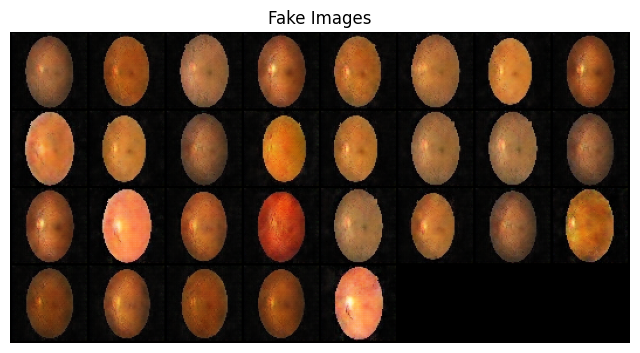

[801/2000][0/9]	Loss_D: 0.0413	Loss_G: 12.3420	D(x): 0.9889	D(G(z)): 0.0001 / 0.0001
[802/2000][0/9]	Loss_D: 0.3451	Loss_G: 15.2204	D(x): 1.0000	D(G(z)): 0.1601 / 0.0002
[803/2000][0/9]	Loss_D: 0.0204	Loss_G: 13.7655	D(x): 0.9948	D(G(z)): 0.0131 / 0.0015
[804/2000][0/9]	Loss_D: 0.0091	Loss_G: 10.9832	D(x): 0.9919	D(G(z)): 0.0009 / 0.0009
[805/2000][0/9]	Loss_D: 0.0511	Loss_G: 8.2363	D(x): 0.9949	D(G(z)): 0.0433 / 0.0019
[806/2000][0/9]	Loss_D: 0.0560	Loss_G: 14.4245	D(x): 0.9513	D(G(z)): 0.0001 / 0.0001
[807/2000][0/9]	Loss_D: 0.0073	Loss_G: 7.0605	D(x): 0.9995	D(G(z)): 0.0067 / 0.0031
[808/2000][0/9]	Loss_D: 0.0058	Loss_G: 7.5661	D(x): 0.9953	D(G(z)): 0.0011 / 0.0015
[809/2000][0/9]	Loss_D: 0.0038	Loss_G: 6.9246	D(x): 0.9997	D(G(z)): 0.0035 / 0.0035
[810/2000][0/9]	Loss_D: 0.0909	Loss_G: 8.0772	D(x): 0.9996	D(G(z)): 0.0595 / 0.0023
[811/2000][0/9]	Loss_D: 0.0701	Loss_G: 16.7962	D(x): 0.9574	D(G(z)): 0.0109 / 0.0007
[812/2000][0/9]	Loss_D: 0.0274	Loss_G: 8.2175	D(x): 0.9996	D(G(z)): 0.

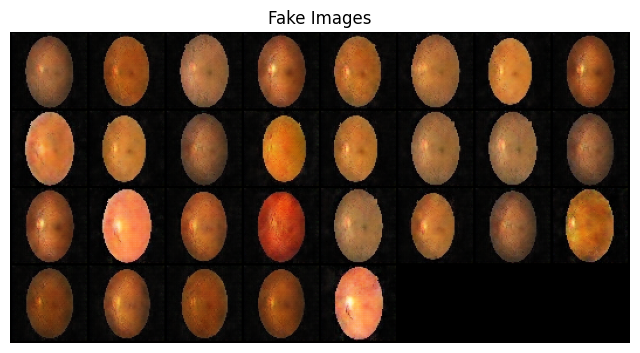

[851/2000][0/9]	Loss_D: 0.0193	Loss_G: 6.8183	D(x): 0.9993	D(G(z)): 0.0169 / 0.0152
[852/2000][0/9]	Loss_D: 0.0036	Loss_G: 8.2472	D(x): 0.9985	D(G(z)): 0.0021 / 0.0015
[853/2000][0/9]	Loss_D: 0.0134	Loss_G: 6.3091	D(x): 0.9972	D(G(z)): 0.0104 / 0.0047
[854/2000][0/9]	Loss_D: 0.7961	Loss_G: 16.3115	D(x): 0.9999	D(G(z)): 0.3386 / 0.0001
[855/2000][0/9]	Loss_D: 0.0046	Loss_G: 8.5415	D(x): 0.9983	D(G(z)): 0.0029 / 0.0022
[856/2000][0/9]	Loss_D: 0.0021	Loss_G: 7.4727	D(x): 0.9995	D(G(z)): 0.0016 / 0.0019
[857/2000][0/9]	Loss_D: 0.2471	Loss_G: 8.1737	D(x): 0.9995	D(G(z)): 0.0459 / 0.0050
[858/2000][0/9]	Loss_D: 0.0189	Loss_G: 13.4162	D(x): 0.9925	D(G(z)): 0.0001 / 0.0005
[859/2000][0/9]	Loss_D: 0.0111	Loss_G: 7.0624	D(x): 0.9955	D(G(z)): 0.0061 / 0.0031
[860/2000][0/9]	Loss_D: 0.0109	Loss_G: 8.5877	D(x): 0.9904	D(G(z)): 0.0009 / 0.0006
[861/2000][0/9]	Loss_D: 0.0039	Loss_G: 7.8550	D(x): 0.9976	D(G(z)): 0.0014 / 0.0015
[862/2000][0/9]	Loss_D: 0.0072	Loss_G: 6.7043	D(x): 0.9965	D(G(z)): 0.0037

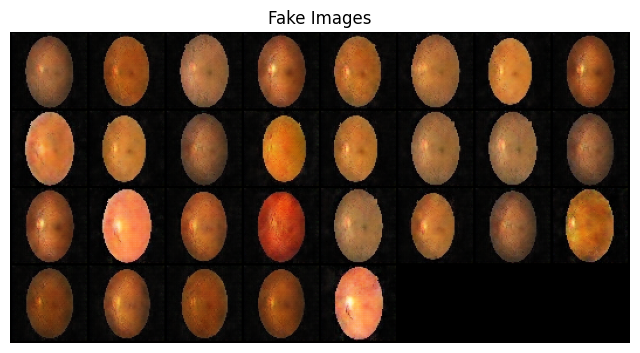

[901/2000][0/9]	Loss_D: 2.5840	Loss_G: 34.7354	D(x): 1.0000	D(G(z)): 0.8365 / 0.0000
[902/2000][0/9]	Loss_D: 0.8135	Loss_G: 17.6328	D(x): 1.0000	D(G(z)): 0.3308 / 0.0001
[903/2000][0/9]	Loss_D: 0.1077	Loss_G: 11.5262	D(x): 0.9976	D(G(z)): 0.0855 / 0.0015
[904/2000][0/9]	Loss_D: 4.4569	Loss_G: 34.4033	D(x): 1.0000	D(G(z)): 0.8846 / 0.0000
[905/2000][0/9]	Loss_D: 0.2157	Loss_G: 9.1246	D(x): 0.9858	D(G(z)): 0.1343 / 0.0024
[906/2000][0/9]	Loss_D: 0.0408	Loss_G: 5.9508	D(x): 0.9982	D(G(z)): 0.0370 / 0.0048
[907/2000][0/9]	Loss_D: 0.0693	Loss_G: 6.7920	D(x): 0.9947	D(G(z)): 0.0539 / 0.0032
[908/2000][0/9]	Loss_D: 0.1899	Loss_G: 8.6559	D(x): 0.9982	D(G(z)): 0.1477 / 0.0013
[909/2000][0/9]	Loss_D: 0.0290	Loss_G: 5.8282	D(x): 0.9936	D(G(z)): 0.0214 / 0.0064
[910/2000][0/9]	Loss_D: 0.4747	Loss_G: 13.5215	D(x): 0.9981	D(G(z)): 0.3073 / 0.0002
[911/2000][0/9]	Loss_D: 0.0282	Loss_G: 6.4792	D(x): 0.9985	D(G(z)): 0.0252 / 0.0040
[912/2000][0/9]	Loss_D: 0.0567	Loss_G: 4.6789	D(x): 0.9649	D(G(z)): 0.0

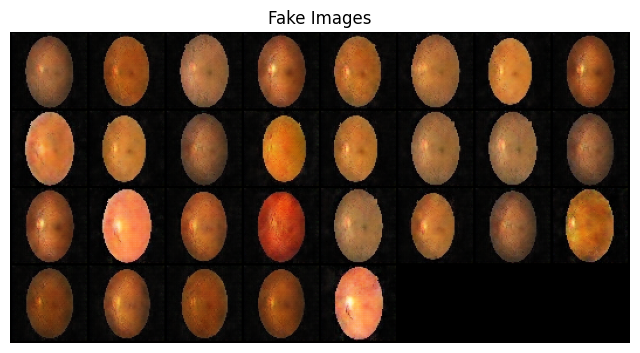

[951/2000][0/9]	Loss_D: 0.0047	Loss_G: 8.1583	D(x): 0.9959	D(G(z)): 0.0006 / 0.0006
[952/2000][0/9]	Loss_D: 0.0031	Loss_G: 6.9881	D(x): 0.9989	D(G(z)): 0.0020 / 0.0017
[953/2000][0/9]	Loss_D: 0.0223	Loss_G: 6.2925	D(x): 0.9994	D(G(z)): 0.0208 / 0.0033
[954/2000][0/9]	Loss_D: 0.3523	Loss_G: 14.2570	D(x): 0.9999	D(G(z)): 0.2423 / 0.0000
[955/2000][0/9]	Loss_D: 0.0030	Loss_G: 8.3975	D(x): 0.9995	D(G(z)): 0.0025 / 0.0025
[956/2000][0/9]	Loss_D: 0.0081	Loss_G: 6.7931	D(x): 0.9960	D(G(z)): 0.0040 / 0.0032
[957/2000][0/9]	Loss_D: 0.0096	Loss_G: 6.7856	D(x): 0.9940	D(G(z)): 0.0035 / 0.0030
[958/2000][0/9]	Loss_D: 0.0292	Loss_G: 5.6310	D(x): 0.9996	D(G(z)): 0.0268 / 0.0075
[959/2000][0/9]	Loss_D: 0.0039	Loss_G: 7.2721	D(x): 0.9981	D(G(z)): 0.0019 / 0.0016
[960/2000][0/9]	Loss_D: 0.0897	Loss_G: 6.2471	D(x): 0.9999	D(G(z)): 0.0795 / 0.0035
[961/2000][0/9]	Loss_D: 0.0036	Loss_G: 6.9656	D(x): 0.9983	D(G(z)): 0.0019 / 0.0017
[962/2000][0/9]	Loss_D: 0.0036	Loss_G: 7.1569	D(x): 0.9982	D(G(z)): 0.0018 

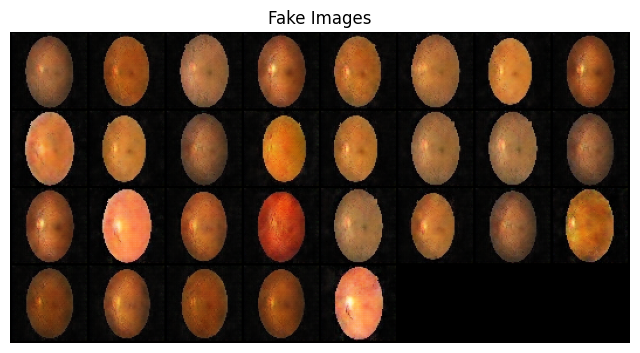

[1001/2000][0/9]	Loss_D: 0.0104	Loss_G: 5.4727	D(x): 0.9997	D(G(z)): 0.0100 / 0.0092
[1002/2000][0/9]	Loss_D: 0.0026	Loss_G: 7.2245	D(x): 0.9996	D(G(z)): 0.0021 / 0.0018
[1003/2000][0/9]	Loss_D: 0.0153	Loss_G: 6.5665	D(x): 0.9957	D(G(z)): 0.0106 / 0.0046
[1004/2000][0/9]	Loss_D: 0.0078	Loss_G: 6.1818	D(x): 0.9982	D(G(z)): 0.0059 / 0.0055
[1005/2000][0/9]	Loss_D: 0.0017	Loss_G: 8.9784	D(x): 0.9997	D(G(z)): 0.0014 / 0.0009
[1006/2000][0/9]	Loss_D: 0.1582	Loss_G: 8.8598	D(x): 0.9999	D(G(z)): 0.1301 / 0.0012
[1007/2000][0/9]	Loss_D: 0.0045	Loss_G: 8.5728	D(x): 0.9999	D(G(z)): 0.0043 / 0.0020
[1008/2000][0/9]	Loss_D: 0.0017	Loss_G: 8.2203	D(x): 0.9992	D(G(z)): 0.0010 / 0.0008
[1009/2000][0/9]	Loss_D: 0.0022	Loss_G: 8.0932	D(x): 0.9993	D(G(z)): 0.0015 / 0.0022
[1010/2000][0/9]	Loss_D: 0.0064	Loss_G: 6.7214	D(x): 0.9979	D(G(z)): 0.0042 / 0.0030
[1011/2000][0/9]	Loss_D: 0.0047	Loss_G: 7.9698	D(x): 0.9970	D(G(z)): 0.0015 / 0.0012
[1012/2000][0/9]	Loss_D: 0.0081	Loss_G: 9.4176	D(x): 0.9966	D(G(z

In [38]:
# Training

# Create the generator
netG = generator()
# netG = nn.DataParallel(netG)
netG.to(device)
print(netG)

# Create the discriminator
netD = discriminator()
# netD = nn.DataParallel(netD)
netD.to(device)
print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
good_Training=False
noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

if __name__=='__main__':
    print("Starting Training Loop...")
    #netG.load_state_dict(torch.load('/kaggle/input/gan-main-test-weights2500/generator.weight'))#,map_location=torch.device('cpu')
    #netD.load_state_dict(torch.load('/kaggle/input/gan-main-test-weights2500/discriminator.weight'))#,map_location=torch.device('cpu')
    netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))#,map_location=torch.device('cpu')
    netD.load_state_dict(torch.load('/kaggle/working/discriminator.weight'))#,map_location=torch.device('cpu')

    for epoch in range(EPOCH_NUM):
        for i, data in enumerate(dataloader, 0):
            # (1) Update the discriminator with real data
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            #print(b_size)

            label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            # (2) Update the discriminator with fake data
            # Generate batch of latent vectors
            noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
            
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(FAKE_LABEL)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            # (3) Update the generator with fake data
            netG.zero_grad()
            label.fill_(REAL_LABEL)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 9 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch+1, EPOCH_NUM, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
        if ((epoch+1)%5==0):
            avgLoss=sum(G_losses[-5:])/5
            if avgLoss>=40:
                print('Exited')
                break
        
        if ((epoch+1)%50==0):
            print("........Saving.......")
            torch.save(netG.state_dict(), '/kaggle/working/generator.weight')
            torch.save(netD.state_dict(), '/kaggle/working/discriminator.weight')
            with torch.no_grad():
                fake = netG(noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            # Plot some fake images
            real_batch = next(iter(img_list))
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("Fake Images")
            plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[50], padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()


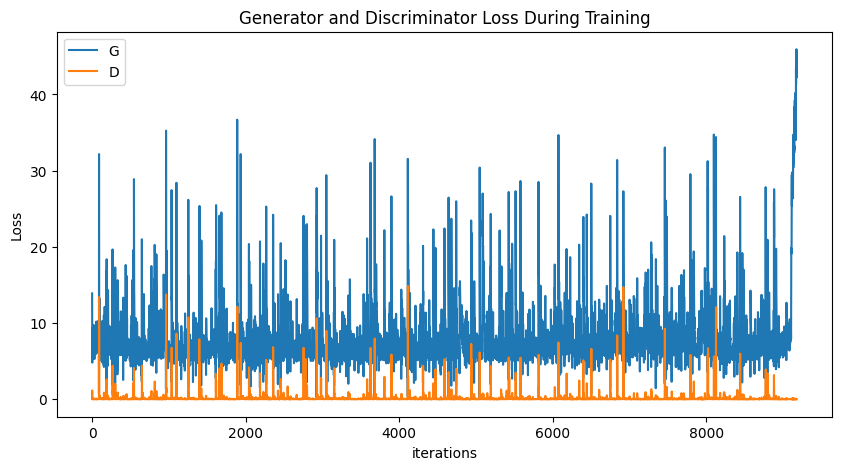

In [39]:
#plot loss graph

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.Size([128, 100, 1, 1])


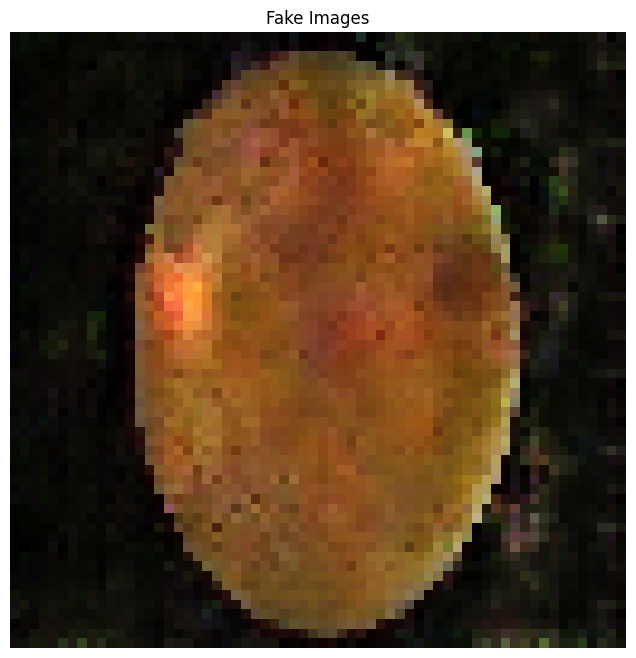

In [41]:
# Generate image

def display_image(dataloader,str):
    # Plot some training images
    Data=dataloader #next(iter(dataloader))
    #print(Data)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"{str} Images")
    plt.imshow(np.transpose(vutils.make_grid(Data[:32],nrow=12, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show() 

if __name__=='__main__':
    netG = generator()
    netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))#,map_location=torch.device('cpu')
    netG.to(device)

    noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
    with torch.no_grad():
        print(noise.shape)
        fake = netG(noise).detach().cpu()#.numpy()
        
    display_image(fake,'Fake')